In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta
from scipy import stats
import matplotlib.pyplot as plt

In [5]:
PORTFOLIO_VALUE = 100000
RISK_FREE_RATE = 0.04

In [6]:
portfolio = pd.read_csv("top_50_HQM.csv")

In [7]:
portfolio.head(10)

,Ticker,Price,HQM_Score,Weight_Pct,Shares_to_Buy
0,WDC,160.100006,99.95,1.41,8
1,WBD,22.760000,99.55,1.13,49
2,STX,275.769989,99.40,1.47,5
3,MU,237.500000,99.09,1.19,5
4,TER,187.589996,98.64,1.27,6
5,LRCX,165.050003,98.29,1.53,9
6,GOOGL,284.309998,97.13,2.26,7
7,KLAC,1227.099976,96.88,1.72,1
8,GOOG,284.750000,96.88,2.29,8
9,FSLR,277.390015,96.32,1.17,4


In [9]:
print(f"Portfolio: {len(portfolio)} stocks")
print(f"Total Weight: {portfolio["Weight_Pct"].sum():.2f}%")

Portfolio: 50 stocks
Total Weight: 100.03%


In [10]:
tickers = portfolio["Ticker"].tolist()

end_date = datetime.now()
start_date = end_date - timedelta(days=365)

prices = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True, progress=True)['Close']
print(f"Downloaded {len(prices)} days of data")

[*********************100%***********************]  49 of 50 completed

1 Failed download:
['MCK']: TypeError("'NoneType' object is not subscriptable")


Downloaded 251 days of data


In [11]:
spy = yf.download("SPY", start=start_date, end=end_date, auto_adjust=True, progress=False)['Close']

In [15]:
weights = portfolio.set_index("Ticker")["Weight_Pct"] / 100
weights = weights.to_dict()

daily_returns = prices.pct_change()
daily_returns = daily_returns.iloc[1:]
daily_returns = daily_returns.fillna(0)

portfolio_returns = pd.Series(0.0, index=daily_returns.index)
for ticker in tickers:
    if ticker in daily_returns.columns:
        portfolio_returns += daily_returns[ticker] * weights.get(ticker, 0)
benchmark_returns = spy.pct_change().dropna()

common_dates = portfolio_returns.index.intersection(benchmark_returns.index)
portfolio_returns = portfolio_returns.loc[common_dates]
benchmark_returns = benchmark_returns.loc[common_dates]

print(f"Calculated {len(portfolio_returns)} days of returns")

Calculated 250 days of returns


C:\Users\nroyc\AppData\Local\Temp\ipykernel_20756\3749167386.py:4: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_returns = prices.pct_change()


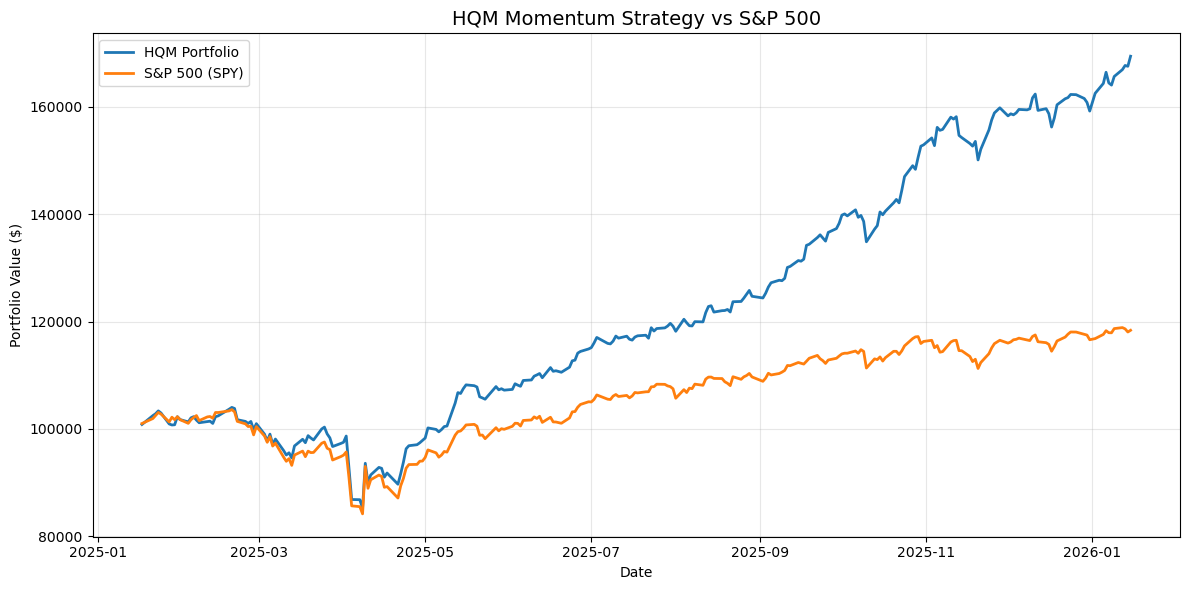

In [16]:
portfolio_cumulative = (1 + portfolio_returns).cumprod()
benchmark_cumulative = (1 + benchmark_returns).cumprod()

portfolio_value = PORTFOLIO_VALUE * portfolio_cumulative
benchmark_value = PORTFOLIO_VALUE * benchmark_cumulative

plt.figure(figsize=(12, 6))
plt.plot(portfolio_value, label='HQM Portfolio', linewidth=2)
plt.plot(benchmark_value, label='S&P 500 (SPY)', linewidth=2)
plt.title('HQM Momentum Strategy vs S&P 500', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [18]:
def calculate_metrics(returns, benchmark_returns, risk_free_rate=RISK_FREE_RATE):
    metrics = {}
    
    # Total Return
    metrics['Total Return (%)'] = ((1 + returns).prod() - 1) * 100
    metrics['Benchmark Return (%)'] = ((1 + benchmark_returns).prod() - 1) * 100
    
    # Annualized Return
    trading_days = len(returns)
    years = trading_days / 252
    metrics['Annualized Return (%)'] = ((1 + metrics['Total Return (%)']/100) ** (1/years) - 1) * 100
    metrics['Benchmark Annualized (%)'] = ((1 + metrics['Benchmark Return (%)']/100) ** (1/years) - 1) * 100
    
    # Volatility
    metrics['Volatility (%)'] = returns.std() * np.sqrt(252) * 100
    
    # Sharpe Ratio
    excess_returns = returns - (risk_free_rate / 252)
    metrics['Sharpe Ratio'] = (excess_returns.mean() / returns.std()) * np.sqrt(252) if returns.std() > 0 else 0
    
    # Sortino Ratio
    downside_returns = returns[returns < 0]
    downside_std = downside_returns.std() * np.sqrt(252)
    metrics['Sortino Ratio'] = (returns.mean() * 252 - risk_free_rate) / downside_std if downside_std > 0 else 0
    
    # Max Drawdown
    cumulative = (1 + returns).cumprod()
    rolling_max = cumulative.expanding().max()
    drawdowns = (cumulative - rolling_max) / rolling_max
    metrics['Max Drawdown (%)'] = drawdowns.min() * 100
    
    # Alpha and Beta
    slope, intercept, r_value, p_value, std_err = stats.linregress(benchmark_returns, returns)
    metrics['Beta'] = slope
    metrics['Alpha (%)'] = intercept * 252 * 100
    
    # Win Rate
    metrics['Win Rate (%)'] = (returns > 0).sum() / len(returns) * 100
    
    # Profit Factor
    gross_profit = returns[returns > 0].sum()
    gross_loss = abs(returns[returns < 0].sum())
    metrics['Profit Factor'] = gross_profit / gross_loss if gross_loss > 0 else float('inf')
    
    return metrics

# Flatten benchmark_returns if it's a DataFrame
if isinstance(benchmark_returns, pd.DataFrame):
    benchmark_returns = benchmark_returns.squeeze()

# Make sure they're aligned
portfolio_returns = portfolio_returns.loc[common_dates]
benchmark_returns = benchmark_returns.loc[common_dates]

print(f"Portfolio returns shape: {portfolio_returns.shape}")
print(f"Benchmark returns shape: {benchmark_returns.shape}")
metrics = calculate_metrics(portfolio_returns, benchmark_returns)

Portfolio returns shape: (250,)
Benchmark returns shape: (250,)


In [21]:
print("HQM Momentum Backtest Results")

print("\nRETURNS")
print(f"  Total Return:        {metrics['Total Return (%)']:>10.2f}%")
print(f"  Annualized Return:   {metrics['Annualized Return (%)']:>10.2f}%")
print(f"  Benchmark Return:    {metrics['Benchmark Return (%)']:>10.2f}%")

print("\nRISK METRICS")
print(f"  Volatility:          {metrics['Volatility (%)']:>10.2f}%")
print(f"  Max Drawdown:        {metrics['Max Drawdown (%)']:>10.2f}%")
print(f"  Beta:                {metrics['Beta']:>10.2f}")

print("\nRISK-ADJUSTED RETURNS")
print(f"  Sharpe Ratio:        {metrics['Sharpe Ratio']:>10.2f}")
print(f"  Sortino Ratio:       {metrics['Sortino Ratio']:>10.2f}")
print(f"  Alpha:               {metrics['Alpha (%)']:>10.2f}%")

print("\nTRADE STATISTICS")
print(f"  Win Rate (Daily):    {metrics['Win Rate (%)']:>10.2f}%")
print(f"  Profit Factor:       {metrics['Profit Factor']:>10.2f}")

HQM Momentum Backtest Results

RETURNS
  Total Return:             69.45%
  Annualized Return:        70.17%
  Benchmark Return:         18.38%

RISK METRICS
  Volatility:               21.18%
  Max Drawdown:            -18.08%
  Beta:                      1.02

RISK-ADJUSTED RETURNS
  Sharpe Ratio:              2.43
  Sortino Ratio:             3.07
  Alpha:                    36.17%

TRADE STATISTICS
  Win Rate (Daily):         61.20%
  Profit Factor:             1.66


In [23]:
metrics_df = pd.DataFrame([metrics]).T
metrics_df.columns = ['Value']
metrics_df.to_csv('hqm_backtest_metrics.csv')